# <b>Proyecto programación 07MIAR 2023</b>

## <b>Autores:</b> Diocles Germán Avendaño Ponces y Gonzalo Rama

## <b>Tema:</b> Deep Vision in classification tasks

## <b>0. Importación de librerías y preparación de ambiente</b>

In [19]:
# Nos aseguramos que tenemos instalada la última versión de la API de Kaggle en Colab o en local
!pip install - -upgrade - -force-reinstall - -no-deps kaggle



Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

no such option: -u


#### <b>0.1. Importamos librerías</b>

In [2]:
# import system libs
import warnings
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras.layers.experimental.preprocessing import Rescaling, RandomFlip, RandomRotation
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import time
import shutil

from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
# import Deep learning Libraries
# Ignore Warnings
warnings.filterwarnings("ignore")

### <b>0.2. Acciones necesarias para ejecutar el trabajo en local</b>

In [3]:
# Directorio destino para el archivo kaggle.json
destination_directory = os.path.join(os.path.expanduser('~'), '.kaggle')

# Crear el directorio .kaggle si no existe
os.makedirs(destination_directory, exist_ok=True)

# Copiar el archivo kaggle.json al directorio .kaggle
shutil.copy('kaggle.json', destination_directory)

# Cambiar los permisos del archivo a lectura y escritura solo para el propietario (necesario para la seguridad)
os.chmod(os.path.join(destination_directory, 'kaggle.json'), 0o600)

### <b>0.3. Acciones necesarias para ejecutar el trabajo en Colab</b>

In [22]:
# Seleccionar el API Token personal previamente descargado (fichero kaggle.json)
# Importaciones en COLAB
'''from google.colab import files
files.upload()'''

# Creamos un directorio en el que copiamos el fichero kaggle.json
'''!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json'''


'!mkdir ~/.kaggle\n!cp kaggle.json ~/.kaggle/\n!chmod 600 ~/.kaggle/kaggle.json'

### <b>0.4. Descarga y procesamiento del dataset</b>

In [23]:
# Descarguemos un dataset de cierta competición
!kaggle datasets download - d gpiosenka/100-bird-species


usage: kaggle [-h] [-v]
              {competitions,c,datasets,d,kernels,k,models,m,files,f,config}
              ...
kaggle: error: unrecognized arguments: d gpiosenka/100-bird-species


In [24]:
# Creemos un directorio para descomprimir los datos
!mkdir dataset


In [25]:
# Descomprimimos los datos y los dejamos listos para trabajar
# Linux o Colab
#!unzip 100-bird-species.zip -d dataset

### <b>0.5. Conexión a Google Drive (solo para colab)</b>

In [26]:
# Conectamos con nuestro Google Drive
'''
from google.colab import drive
drive.mount('/content/drive')
'''
# Movemos el dataset a nuestro drive
#!mv dataset to drive/MyDrive/Colab_Notebooks/07MIAR_2023/Proyecto

"\nfrom google.colab import drive\ndrive.mount('/content/drive')\n"

## <b>1. Carga de datos<b>

#### Ruta del Dataset

In [4]:
# Establezco una ruta absoluta a un directorio existente de mi Google Drive
# BASE_FOLDER = "drive/MyDrive/Colab_Notebooks/07MIAR_2023/Proyecto/"

# Establezco una ruta absoluta a un directorio existente de mi local
BASE_FOLDER = "D:/Elementos/Main/Maestria/Asignaturas/Deep Learning/Actividades/Proyecto/07MIAR/"

BASE_DATASET = BASE_FOLDER + "dataset/"
BASE_MODEL = BASE_FOLDER + "models/"

### <b> 1.1. Declaración de funciones de carga de datos</b>

In [7]:
def load_data(folder):
    train_dir = BASE_FOLDER+folder
    filepaths = []
    labels = []

    folds = os.listdir(train_dir)
    for fold in folds:
        foldpath = os.path.join(train_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    # Concatenación rutas de datos con etiquetas en un DataFrame
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')
    return pd.concat([Fseries, Lseries], axis=1)


def load_data_from_directory(folder, shuffle):
    return tf.keras.preprocessing.image_dataset_from_directory(BASE_DATASET + folder, batch_size=32, image_size=(224, 224), shuffle=shuffle)


def file_verifier_data_classes(title, df, shuffle):
    print(f'\n{title}')
    return ImageDataGenerator().flow_from_dataframe(df, x_col='filepaths', y_col='labels', target_size=(224, 224), class_mode='categorical',
                                                    color_mode='rgb', shuffle=shuffle, batch_size=32)

### 1.1.2. Carga de conjuto de datos (entrenamiento, validación y prueba)

In [8]:
train_ds = load_data_from_directory('train', True)
valid_ds = load_data_from_directory('valid', True)
test_ds = load_data_from_directory('test', True)

Found 84635 files belonging to 525 classes.
Found 2625 files belonging to 525 classes.
Found 2625 files belonging to 525 classes.


## <b>2. Inspección del conjunto de datos</b>

### <b> 2.1. Declaración de funciones de inspección de datos</b>

In [9]:
def show_data_form(dataset):
    for images, labels in dataset.take(1):
        print("Forma de las imágenes: ", images.shape)
        print("Forma de las etiquetas: ", labels.shape)
        print("Clases únicas en el conjunto de entrenamiento: ",
              len(dataset.class_names))


def show_images(dataset):
    class_names = dataset.class_names

    # Configurar matplotlib
    plt.figure(figsize=(15, 15))

    # Contador para mostrar solo 16 imágenes
    image_count = 0

    # Iterar sobre el conjunto de datos
    for images, labels in dataset:
        for i in range(len(images)):
            # Incrementar el contador y mostrar la imagen y su etiqueta
            image_count += 1
            ax = plt.subplot(4, 4, image_count)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

            # Parar cuando se hayan mostrado 16 imágenes
            if image_count == 16:
                break

        if image_count == 16:
            break

    plt.show()

### <b>2.2. Inspección de forma de datos</b>

In [10]:
show_data_form(train_ds)


Forma de las imágenes:  (32, 224, 224, 3)
Forma de las etiquetas:  (32,)
Clases únicas en el conjunto de entrenamiento:  525


### 2.2.1. Inspección aleatoria de las imágenes

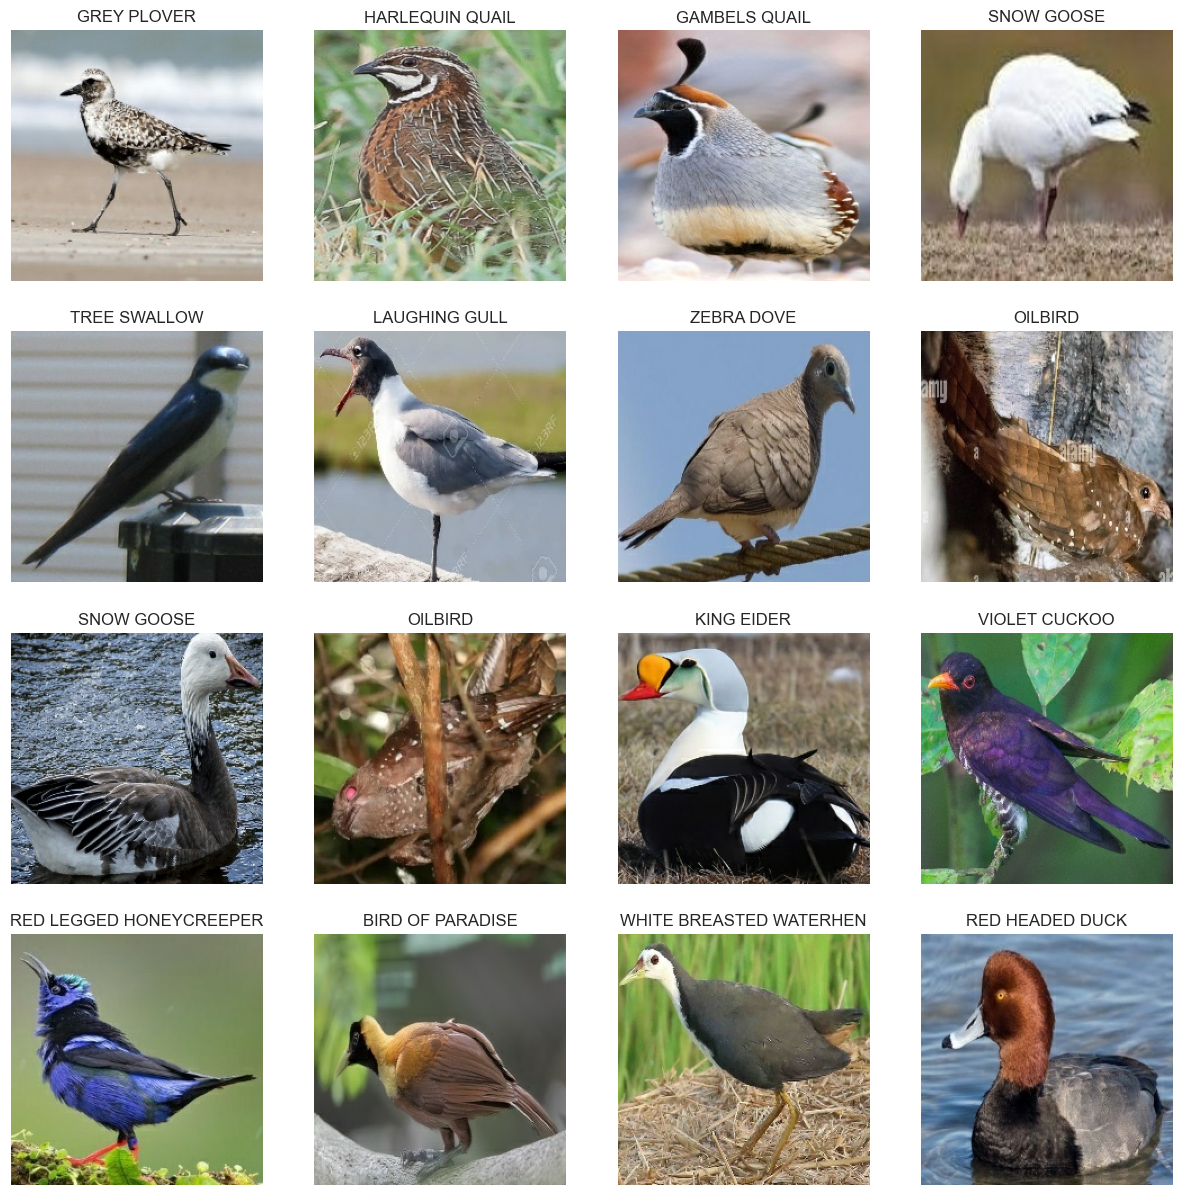

In [11]:
show_images(train_ds)


## <b>3. Acondicionamiento del conjunto de datos</b>

In [12]:
# Normalización y aumento de datos
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2)
])

train_da = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
train_da = train_ds.map(lambda x, y: (Rescaling(1./255)(x), y))
valid_da = valid_ds.map(lambda x, y: (Rescaling(1./255)(x), y))
test_da = test_ds.map(lambda x, y: (Rescaling(1./255)(x), y))

shape = (224, 224, 3)

# <b>Estrategia 1: Entrenar desde cero o from scratch</b>

## <b>4. Análisis y selección de arquitectura CNN</b>

Se realizó una investigación para saber cuales son las arquitecturas CNN de clasificación multiclase con imágenes más usadas y con mejores resultados, con el fin de delimitar las arquitectura a probar y seleccionar para el presente trabajo.
<br>Según <b>[1]</b> en su trabajo tituloado "Consecutive multiscale feature learning-based image classification model" las siguientes arquitecturas son las que más destacan:

1. <b> Residual Networks (ResNets):</b> Estas redes son una de las primeras y más poderosas arquitecturas de CNN basadas en aprendizaje profundo para la clasificación de imágenes. Se destacan por reformular las capas para aprender funciones residuales en relación con las entradas de las capas, lo que facilita la optimización y mejora la precisión gracias a la profundidad aumentada de la red​​.

2. <b>Dense Convolutional Network (DenseNet):</b> Esta red conecta cada capa con todas las demás en una propagación hacia adelante, lo que le permite manejar el problema del gradiente desvaneciente, asegurar el intercambio de características y reducir significativamente el número de parámetros entrenables​​.

3. <b>ShuffleNet:</b> Junto con MobileNet y MnasNet, ShuffleNet es uno de los modelos de clasificación más ampliamente empleados en dispositivos con potencia computacional limitada debido a su eficiencia y bajo requisito de memoria. Utiliza la convolución de grupos y la mezcla de canales para reducir significativamente los gastos computacionales mientras mantiene una precisión competitiva​​.

Como da a conocer <b>[1]</b> esta arquitecturas se destacan por su eficiencia y capacidad para manejar diversas tareas de clasificación de imágenes, lo que las convierte en opciones populares en la comunidad de visión por computadora

## <b>5. Desarrollo de la Arquitectura de Red Neuronal y Entrenamiento</b>


### <b>5.1.  Funciones de las arquitecturas a usar</b>

In [23]:
# Construcción del modelo ResNet
def resnet_block(input_data, filters, kernel_size):
    x = layers.Conv2D(filters, kernel_size=(kernel_size, kernel_size), activation='relu',
                      padding='same')(input_data)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters,kernel_size=(kernel_size, kernel_size), activation=None, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, input_data])
    x = layers.Activation('relu')(x)
    return x

# Crear un modelo funcional ResNet


def resnet_training(shape, filter, kernel_size, activation, activation2, epoch, padding, pooling, name, lr, b1,b2, e):
    inputs = layers.Input(shape=shape)
    x = layers.Conv2D(filter, kernel_size=(kernel_size, kernel_size), padding=padding , activation=activation)(inputs)
    x = layers.Conv2D(int(filter*2), kernel_size, activation=activation)(x)
    x = layers.MaxPooling2D(pool_size=(pooling,pooling))(x)
    for _ in range(epoch):
        x = resnet_block(x, int(filter*2), kernel_size)
    x = layers.Conv2D(int(filter*4), kernel_size=(kernel_size, kernel_size), padding=padding, activation=activation)(x)
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(len(train_ds.class_names),
                           activation=activation2)(x)
    resnet_model = models.Model(inputs, outputs)

    # Compilación del modelo
    resnet_model.compile(
        optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Entrenamiento del modelo
    history = resnet_model.fit(train_da, validation_data=valid_da, epochs=epoch)
    resnet_model.save(f'{BASE_MODEL}{name}.h5')
    return history

In [18]:
#2
resnet_training(shape, 5,3, 'relu', 'softmax', 1, 'same', 2, 'res_net2')

2645/2645 [==============================] - 105s 40ms/step - loss: 5.8967 - accuracy: 0.0112 - val_loss: 5.6255 - val_accuracy: 0.0156


In [20]:
#3
resnet_training(shape, 32,3, 'relu', 'softmax', 1, 'valid', 2, 'res_net3')

2645/2645 [==============================] - 476s 180ms/step - loss: 5.5468 - accuracy: 0.0303 - val_loss: 4.8778 - val_accuracy: 0.0785


In [21]:
#4
resnet_training(shape, 32,3, 'relu', 'softmax', 1, 'valid', 2, 'res_net4',0.001,0.9,0.999,1e-08)

2645/2645 [==============================] - 486s 183ms/step - loss: 5.6050 - accuracy: 0.0272 - val_loss: 5.0437 - val_accuracy: 0.0549


In [25]:
#5
resnet_training(shape, 32,3, 'relu', 'softmax', 3, 'same', 2, 'res_net5',0.001,0.9,0.999,1e-08)

Epoch 1/3
2645/2645 [==============================] - 768s 290ms/step - loss: 5.8931 - accuracy: 0.0118 - val_loss: 5.4118 - val_accuracy: 0.0259
Epoch 2/3
2645/2645 [==============================] - 761s 288ms/step - loss: 5.1809 - accuracy: 0.0449 - val_loss: 4.9409 - val_accuracy: 0.0716
Epoch 3/3
2645/2645 [==============================] - 762s 288ms/step - loss: 4.5806 - accuracy: 0.0972 - val_loss: 4.3029 - val_accuracy: 0.1326


### <b>5.2.  Construcción de ResNet desde cero</b>


## <b>6. Monitorización del Proceso de Entrenamiento</b>


In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")

history = resnet_model.fit(
    train_da,
    validation_data=valid_da,
    epochs=10,
    callbacks=[tensorboard_callback]
)


## <b>7. Evaluación del Modelo y Siguiente Prueba Experimental</b>


In [94]:
test_loss, test_accuracy = resnet_model.evaluate(test_da)
print("Pérdida en el test: ", test_loss)
print("Precisión en el test: ", test_accuracy)
# Ideas para la siguiente experimentación:
# 1. Ajustar el número de bloques ResNet.
# 2. Implementar técnicas de regularización como Dropout.
# 3. Probar diferentes optimizadores o tasas de aprendizaje.
# 4. Utilizar el aprendizaje por transferencia en lugar de entrenar desde cero


83/83 [==============================] - 21s 221ms/step - loss: 5.0654 - accuracy: 0.0396
Pérdida en el test:  5.065388202667236
Precisión en el test:  0.039619047194719315


# <b>Bibliografía</b>

<b>[1]</b> Olimov, B., Subramanian, B., Ugli, R. A. A., Kim, J.-S., & Kim, J. (2023). Consecutive multiscale feature learning-based image classification model. Scientific Reports, 13(1). https://doi.org/10.1038/s41598-023-30480-8
